In [7]:
import numpy as np
import glob
import sys
import time
import datetime
import os
import pickle
import threading
from enum import Enum

import matplotlib.pyplot as plt

In [2]:
%matplotlib nbagg

Utilities
---------

In [3]:
def printError(*arg):
    print('Error:', *arg, file=sys.stderr)
    
def printDebug(*arg):
    print('Debug:', *arg, file=sys.stderr)
    
def printWarning(*arg):
    print('Warning:', *arg, file=sys.stderr)

Simulation Model
----------------

In [4]:
class WaterHeaterModel:
    def __init__(self, m_w=1, m_h=0.2, T_env=23, P=400, r=0.085,
                 c_pw=4200, c_ph=400, h_w=25, h_a=6, rho_w=1000, rho_h=8800):
        A_hw = np.pi * r ** 2
        V_w = m_w / rho_w
        H_w = V_w / A_hw
        A_wa = H_w * 2 * r * np.pi + A_hw

        V_h = m_h / rho_h
        H_h = V_h / A_hw
        A_ha = H_h * 2 * r * np.pi + A_hw

        alpha = -(h_w * A_hw + h_a * A_ha) / (c_ph * m_h)
        beta = h_w * A_hw / (c_ph * m_h)
        gamma = h_w * A_hw / (c_pw * m_w)
        delta = -(h_w * A_hw + h_a * A_wa) / (c_pw * m_w)

        self.A = np.array([[alpha, beta], [gamma, delta]])

        alpha = P / (c_ph * m_h)
        beta = h_a * A_ha / (c_ph * m_h) * T_env
        gamma = 0
        delta = h_a * A_wa / (c_pw * m_w) * T_env

        self.B = np.array([[alpha, beta], [gamma, delta]])
        
        self.state = np.array([[T_env] * 2], dtype=np.float64).transpose()

    def __call__(self, u, dt):
        u = np.array([[u, 1]]).transpose()
        
        self.state += (np.dot(self.A, self.state) + np.dot(self.B, u)) * dt
        
        return self.state

Simulator Interface
-------------------

In [5]:
class SimulatorInterface:
    def __init__(self, m=None, time_base=datetime.datetime.now, time_factor=1.0, switching_delay=5.0, accuracy=0.125):
        if m is None:
            m = np.random.rand() + 0.7
        
        self.model = WaterHeaterModel(m)
        self.heating = False
        self.time_base = time_base
        self.last_time = time_base()
        self.time_factor = time_factor
        self.switching_delay = switching_delay
        self.accuracy = accuracy
        self.last_temperature = np.random.rand() * 80 + 20
        self.relays = []
    
    def _update(self):
        current = self.time_base()
        dt = (current - self.last_time).total_seconds() * self.time_factor
        self.advance(dt, current)
        
    def advance(self, dt, current=None):
        if current is None:
            current = self.time_base()
        self.last_time = current
        
        self.relays = [(x[0] - dt, x[1]) for x in self.relays]
        
        while len(self.relays) > 0 and self.relays[0][0] <= 0:
            self.heating = self.relays[0][1]
            self.relays = self.relays[1:]
        
        self.model(float(self.heating), dt)
    
    def read_temperature(self):
        # note: ugly delay like we have in the actual sensor readings
        result = np.round(self.last_temperature / self.accuracy + np.random.randn(1)[0] / 3) * self.accuracy
        self._update()
        self.last_temperature = self.model.state[1][0]
        return result
    
    def write_relay(self, value):
        self._update()
        self.relays.append((self.switching_delay, value))
            
    def close(self):
        pass

Hardware interface
------------------

In [6]:
class ElectronicsInterface:
    def __init__(self, gpio_pin=18, sensor=None):
        self.pin = gpio_pin
        self.sensor = None
        self.GPIO = None
        
        if sensor is None:
            temperature_sensors = glob.glob('/sys/bus/w1/devices/28-*/w1_slave')
            
            if len(temperature_sensors) > 1:
                printError('multiple temperature sensors found, please specify - entering fake mode')
                return
            elif len(temperature_sensors) == 0:
                printError('temperature sensor cannot be found - entering fake mode')
                return
            else:
                printDebug('temperature sensor found: ' + temperature_sensors[0])
                sensor = temperature_sensors[0]
        
        self.sensor = sensor
        
        try:
            self.read_temperature()
        except:
            printError('temperature sensor cannot be read - entering fake mode.')
            self.sensor = None
            return
        
        try:
            import RPi.GPIO as GPIO
            
            GPIO.setmode(GPIO.BCM)
            GPIO.setup(gpio_pin, GPIO.OUT, initial=GPIO.LOW)
            
            self.GPIO = GPIO
            
            printDebug('GPIO up and running')
        except:
            self.GPIO = None
            printError('GPIO not working - entering fake mode')
            
    def read_temperature(self):
        if self.sensor is not None:
            with open(self.sensor, 'r') as f:
                lines = f.readlines()
        else:
            lines = ['69 01 ff ff 7f ff ff ff 7e : crc=7e YES\n', '69 01 ff ff 7f ff ff ff 7e t=22562\n']
            
        if lines[0].strip()[-3:] == 'YES':
            self.temperature = int(lines[1].strip().split('=')[1]) / 1000
        else:
            self.temperature = np.nan
            printWarning('no temperature read')
            
        return self.temperature
    
    def write_relay(self, value):
        if self.GPIO is not None:
            self.GPIO.output(self.pin, value)
            
    def close(self):
        if self.GPIO is not None:
            self.GPIO.cleanup(self.pin)

Controller
----------

In [34]:
class LogStorage:
    def __init__(self):
        self.storage = {}
        
    def store(self, what, when, value):
        if what not in self.storage:
            self.storage[what] = []
            
        self.storage[what].append((when, value))

In [72]:
class CookerController(threading.Thread):
    class States(Enum):
        BOOST = 1
        OVERSHOOT = 2
        CONTROL = 3
        
    CONTROL_EPSILON = 0.5
    F_SWITCH = 1 / 15
    T_CONT = 2 / F_SWITCH
    F_READ = 1
    T_READ = 1 / F_READ
    N_CONTROL = int(T_CONT / T_READ)
    NE_CONTROL = 4

    NM_CONTROL = 3
    NC_CONTROL = 4

    CONTROL_MIN_CHANGE_TIME = 5 * 60 // N_CONTROL

    TARGET_ACCURACY = 0.2
    MAXIMUM_CONTROL_ERROR = 1.0
    BOOST_COOL_SAMPLES = 30
    MIN_BOOST_DURATION_FOR_V_UPDATE = 30
    MAX_V_BOOST = 20
    MIN_V_BOOST = 10
    
    def __init__(self, interface, storage=None):
        threading.Thread.__init__(self)
        self.time_factor = 1
        self.interface = interface
        self.storage = storage
    
        self.now = datetime.datetime.now()
    
        self.v_boost = 15
        
        if self.storage:
            self.storage.store('v_boost', self.now, self.v_boost)
        
        # read once to trigger temperature sensor readings (aka first reading might be outdated)
        interface.read_temperature()
        
        self.state = CookerController.States.OVERSHOOT

        self.relay_on = False
        interface.write_relay(False)

        self.current_mean = 0

        self.set_target(40)

        self.control_a = 0.1
        self.control_n = 0
        self.control_means = []
        
        self.control_cycle_state = 0

        self.control_applied_change = False
        self.control_last_change = 0

        self.control_turnoff = 0

        self.start_state = True

        self.boost_time = 0
        self.boost_cool = 0
        self.boost_heat = 0
        self.boost_samples = 0
        self.boost_start = 0

    def run(self):
        self.running = True
        
        self.iteration = 0
        self.start_time = datetime.datetime.now()
        self.handling_temps = []
        self.now = datetime.datetime.now()
        
        while(self.running):
            self.timestep()
        
        if self.relay_on:
            self.interface.write_relay(False)
            self.relay_on = False
        
    def set_target(self, value):
        # TODO: consider changes while cooking?!
        self.target_temperature = value
        
        self.control_last_min = self.target_temperature - CookerController.MAXIMUM_CONTROL_ERROR
        self.control_last_max = self.target_temperature + CookerController.MAXIMUM_CONTROL_ERROR
        
        self.control_max = 0.07
        self.control_min = 0.02
        
        if self.storage:
            self.storage.store('control_min', self.now, self.control_min)
            self.storage.store('control_max', self.now, self.control_max)
        
    def set_control_a(self, value, state=None):
        self.control_a = value
        
        if self.storage:
            self.storage.store('control_a', self.now, value)
            
        if state is not None:
            self.control_cycle_state = state
            
            if self.storage:
                self.storage.store('control_cycle_state', self.now, self.control_cycle_state)
        
    def timestep(self):
        self.iteration += 1
        self.last_time = self.now
        self.now = datetime.datetime.now()
        
        self.temperature = self.interface.read_temperature()
        
        if self.storage:
            self.storage.store('temperature', self.now, self.temperature)

        self.handling_temps.append(self.temperature)
        
        # delta time
        self.dt = (self.now - self.last_time).total_seconds() * self.time_factor
        
        if self.control_turnoff > 0:
            self.control_turnoff -= self.dt
        if self.boost_time > 0:
            self.boost_time -= self.dt

        self.relay_target = self.relay_on

        # state routines
        if self.state == CookerController.States.CONTROL:
            self.control()
        elif self.state == CookerController.States.BOOST:
            self.boost()
        elif self.state == CookerController.States.OVERSHOOT:
            self.overshoot()

        # actually switch the relay!
        if self.relay_on != self.relay_target:
            self.relay_on = self.relay_target
            self.interface.write_relay(self.relay_on)
            
            if self.storage:
                self.storage.store('relay', self.now, self.relay_on)

        # file controlled emergency stop
        if os.path.exists('/tmp/stop'):
            self.running = False
            return

        # sleep time
        sleep_time = self.iteration + 1 - (datetime.datetime.now() - self.start_time).total_seconds() * self.time_factor

        # precise relay control for control
        if self.state == CookerController.States.CONTROL and self.relay_on and sleep_time > self.control_turnoff:
            if self.control_turnoff > 0:
                time.sleep(self.control_turnoff / self.time_factor)
                sleep_time -= self.control_turnoff
            self.control_turnoff = 0
            self.relay_on = False
            self.interface.write_relay(self.relay_on)
            
            if self.storage:
                self.storage.store('relay', self.now, self.relay_on)

        if sleep_time > 0:
            time.sleep(sleep_time / self.time_factor)
    
    def switch_state(self, state):
        self.state = state
        self.start_state = True
        if self.storage:
            self.storage.store('state', self.now, self.state.value)
        
    def control(self):
        self.control_n += 1
        
        if self.start_state:
            self.control_n = 0
            self.control_means = []
            
            self.control_cycle_state = 0
            
            if self.storage:
                self.storage.store('control_cycle_state', self.now, self.control_cycle_state)
                
            self.control_last_change = 0
            self.control_applied_change = False

            self.start_state = False
        
        # control period is over
        if self.control_n == CookerController.N_CONTROL:
            self.control_last_change += 1
            
            self.control_n = 0

            self.current_mean = np.mean(self.handling_temps[-CookerController.N_CONTROL:])
            
            # mean temperature in last control period
            self.control_means.append(self.current_mean)
            
            if self.storage:
                self.storage.store('control_cycle_mean', self.now, self.current_mean)
            
            # mean temperature was higher than target
            if self.current_mean > self.target_temperature:
                if self.control_cycle_state == 0:
                    # cycle just started, we start controlling with the minimum
                    self.set_control_a(self.control_min, 1)
                elif self.control_cycle_state == 2:
                    # cycle is over
                    
                    # if the difference between min and max is big enough adapt!
                    if self.control_max - self.control_min > 0.01:
                        if np.mean(self.control_means) > self.target_temperature:
                            # on average we were higher than the target -> lower the max
                            self.control_max -= 0.25 * (self.control_max - self.control_min)
                            if self.storage:
                                self.storage.store('control_max', self.now, self.control_max)
                        else:
                            # on average we were lower than the target -> increase the min
                            self.control_min += 0.25 * (self.control_max - self.control_min)
                            if self.storage:
                                self.storage.store('control_min', self.now, self.control_min)

                    self.set_control_a(self.control_min, 1)
                            
                    self.control_last_min = np.min(self.control_means)
                    self.control_last_max = np.max(self.control_means)

                    self.control_applied_change = False
                            
                    self.control_means = []
                elif self.current_mean > self.control_last_max and (not self.control_applied_change or self.control_last_change >= CookerController.CONTROL_MIN_CHANGE_TIME):
                    # temperature is bigger than last max - probably increased the min too much
                    self.control_min -= 0.25 * (self.control_max - self.control_min)
                    
                    if self.storage:
                        self.storage.store('control_min', self.now, self.control_min)
                    
                    self.set_control_a(self.control_min)
                    self.control_applied_change = True
                    self.control_last_change = 0
                    
            elif self.current_mean < self.target_temperature:
                if self.control_cycle_state == 1:
                    # wait for cycling up again
                    self.set_control_a(self.control_max, 2)
                    self.control_applied_change = False
                elif self.current_mean < self.control_last_min and (not self.control_applied_change or self.control_last_change >= CookerController.CONTROL_MIN_CHANGE_TIME):
                    # temperature is lower than last min - probably decreased max too much
                    self.control_max += 0.25 * (self.control_max - self.control_min)
                    
                    if self.storage:
                        self.storage.store('control_max', self.now, self.control_max)
                    
                    self.set_control_a(self.control_max)
                    self.control_applied_change = True
                    self.control_last_change = 0
            
            # state switches
            if self.current_mean > self.target_temperature + CookerController.MAXIMUM_CONTROL_ERROR:
                self.control_max /= 2
                self.control_min /= 2
                
                if self.storage:
                    self.storage.store('control_min', self.now, self.control_min)

                
                self.switch_state(CookerController.States.OVERSHOOT)
                
            elif self.current_mean < self.target_temperature - CookerController.MAXIMUM_CONTROL_ERROR:
                self.switch_state(CookerController.States.BOOST)
                
                self.control_max *= 1.5
                
                if self.storage:
                    self.storage.store('control_max', self.now, self.control_max)

        
        # turn relay on
        if self.control_n == 0 and self.state == CookerController.States.CONTROL:
            self.control_turnoff = self.control_a * CookerController.T_CONT
            
            if self.control_turnoff > 0:
                self.relay_target = True
                
    def boost(self):
        if self.start_state:
            self.boost_start = self.handling_temps[-1]
            dT = self.target_temperature - self.boost_start
            self.boost_time = self.v_boost * dT
            self.boost_heat = self.boost_time
            self.boost_samples = 0
            
            self.relay_target = True
            self.start_state = False
        else:
            self.boost_samples += 1
        
        if self.boost_time <= 0:
            if self.relay_on:
                self.relay_target = False
                self.boost_heat -= self.boost_time
                self.boost_cool = 0
            else:
                self.boost_cool += self.dt
                
                if self.boost_cool > CookerController.BOOST_COOL_SAMPLES:
                    if np.mean(np.array(self.handling_temps[-CookerController.BOOST_COOL_SAMPLES - 1:-1]) - np.array(self.handling_temps[-CookerController.BOOST_COOL_SAMPLES:])) > 0:
                        
                        max_temp = np.max(self.handling_temps[-self.boost_samples:])
                        # TODO: what if it didn't heat yet, but temperature decreased during "cooling"
                        #    - doing nothing will boost the same amount again, which prob. is fine...
                        
                        if self.boost_heat > CookerController.MIN_BOOST_DURATION_FOR_V_UPDATE and max_temp > self.boost_start:
                            self.v_boost = np.max([np.min([self.boost_heat / (max_temp - self.boost_start), CookerController.MAX_V_BOOST]), CookerController.MIN_V_BOOST])
                            
                            if self.storage:
                                self.storage.store('v_boost', self.now, self.v_boost)
                        
                        # state switch
                        if self.handling_temps[-1] > self.target_temperature:
                            self.switch_state(CookerController.States.OVERSHOOT)
                        elif self.handling_temps[-1] > self.target_temperature - CookerController.CONTROL_EPSILON:
                            self.switch_state(CookerController.States.CONTROL)
                        else:
                            self.start_state = True
        
        # overshooting, stop heating early!
        elif self.relay_on and self.handling_temps[-1] >= self.target_temperature:
            self.relay_target = False
            self.boost_heat -= self.boost_time
            self.boost_time = 0
            self.boost_cool = 0
                
    def overshoot(self):
        self.start_state = False
        self.relay_target = False

        if self.handling_temps[-1] < self.target_temperature - CookerController.CONTROL_EPSILON:
            self.switch_state(CookerController.States.BOOST)
        elif self.handling_temps[-1] < self.target_temperature:
            self.switch_state(CookerController.States.CONTROL)
    
    def stop(self):
        self.running = False
        self.join()

Let's try it
------------

In [89]:
interface = ElectronicsInterface()

if interface.sensor is None:
    interface.close()
    interface = SimulatorInterface(time_factor=100.0)

target_temperature = 64.5

Error: temperature sensor cannot be found - entering fake mode


In [90]:
storage = LogStorage()

controller = CookerController(interface, storage)
controller.time_factor = getattr(interface, 'time_factor', 1)
controller.set_target(target_temperature)

In [91]:
controller.start()

In [87]:
controller.stop()
interface.close()

<IPython.core.display.Javascript object>


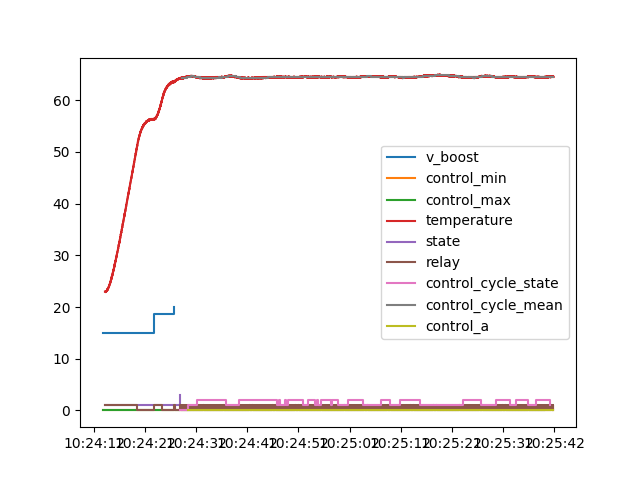

In [98]:
fig = plt.figure()

legend = []

for name, data in storage.storage.items():
    times = []
    values = []
    
    for d1, d2 in zip(data, data[1:]):
        times.append(d1[0])
        times.append(d2[0])
        values.append(d1[1])
        values.append(d1[1])
    
    times.append(data[-1][0])
    values.append(data[-1][1])
    
    plt.plot(times, values)
    legend.append(name)
    
plt.legend(legend)